In [261]:
import pandas as pd 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as tick 
import seaborn as sns 
import glob
from matplotlib.gridspec import GridSpec
from src.files import FASTAFile, InterProScanFile
from tqdm import tqdm
from src.reference import annotate
import src.reference as reference
from scipy.stats import chisquare, chi2_contingency, mannwhitneyu
from scipy.stats.contingency import expected_freq
import re
from src.files import BLASTJsonFile

%load_ext autoreload 
%autoreload 2

get_percent = lambda n, total : f'{100 * n / total:.2f}%' if (total > 0) else '0%'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset_df = pd.read_csv('../data/results/results-2/dataset.csv', index_col=0)
all_hits_df = pd.read_csv('../data/results/results-2/all_hits.csv', index_col=0)

dataset_df = annotate(dataset_df)
all_hits_df = annotate(all_hits_df, prefix='subject')

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 
dataset_df = dataset_df[~dataset_df.genome_id.isin(exclude_genome_ids)].copy()

interpro_df = pd.concat([InterProScanFile(path).to_df() for path in glob.glob('../data/interpro/*')])
ids_with_antifam_hit = interpro_df[interpro_df.interpro_analysis == 'AntiFam'].index.unique()
ids_with_antifam_hit = np.intersect1d(ids_with_antifam_hit, dataset_df.index) # Make sure to remove AntiFam hits from the excluded genomes.
dataset_df['antifam_hit'] = dataset_df.index.isin(ids_with_antifam_hit)

antifam_interpro_df = interpro_df.loc[ids_with_antifam_hit].sort_values('interpro_e_value')
antifam_interpro_df = antifam_interpro_df[~antifam_interpro_df.index.duplicated(keep='first')].copy()

print('Num. proteins with AntiFam hit:', len(ids_with_antifam_hit))
for description, df in antifam_interpro_df.groupby('interpro_signature_description'):
    description = description[0].lower() + description[1:]
    print(f'\tNum. {description}:', len(df))


Num. proteins with AntiFam hit: 27
	Num. antisense to 23S rRNA: 5
	Num. antisense to RNaseP: 2
	Num. translation of CRISPR region: 9
	Num. tRNA translation: 11


In [163]:
is_cds_conflict = lambda df : (df.conflict) & (df.top_hit_feature == 'CDS') & (~df.top_hit_pseudo)
is_antiparallel_cds_conflict = lambda df : is_cds_conflict(df) & (df.overlap_type.isin(['convergent', 'divergent']))
is_hypothetical_cds_conflict = lambda df : df.conflict & (df.top_hit_product == 'hypothetical protein')
is_supported_cds_conflict = lambda df : is_cds_conflict(df) & (~df.top_hit_unsupported)
is_unsupported_cds_conflict = lambda df : is_cds_conflict(df) & (df.top_hit_unsupported)
is_non_coding_conflict = lambda df : df.conflict & (df.top_hit_feature != 'CDS')

def is_top_hit_match(row, exact:bool=False):
    mask = (dataset_df.top_hit_contig_id == row.top_hit_contig_id)
    mask = mask & dataset_df.exact_match if exact else dataset_df.match
    mask = mask & (dataset_df.top_hit_locus_tag == row.top_hit_locus_tag)
    # assert mask.sum() <= 1, f'top_hit_has_match: Expected there to be at most one match, but found {mask.sum()}.'
    return mask.sum() > 0

def is_top_hit_match_in_conflict(row):
    if not row.conflict:
        return False
    mask = (dataset_df.top_hit_contig_id == row.top_hit_contig_id) & dataset_df.match
    mask = mask & (dataset_df.top_hit_locus_tag == row.top_hit_locus_tag)
    if mask.sum() < 1: # Then there is no match. 
        return False 
    assert mask.sum() == 1, f'top_hit_has_match: Expected there to be at most one match, but found {mask.sum()}.'
    top_hit_match = dataset_df[mask].iloc[0]
    return not ((row.query_stop < top_hit_match.query_start) or (row.query_start > top_hit_match.query_stop))
    
# dataset_df['top_hit_match'] = dataset_df.apply(is_top_hit_match, axis=1)
# dataset_df['top_hit_exact_match'] = dataset_df.apply(lambda row : is_top_hit_match(row, exact=True), axis=1)
# dataset_df['top_hit_match_in_conflict'] = dataset_df.apply(is_top_hit_match_in_conflict, axis=1)

In [7]:
threshold = 0.9

results_df = pd.read_csv('../data/results/results-2/dataset_predict.csv', index_col=0)
results_df.columns = [col.replace('_v2', '') for col in results_df.columns]
results_df = results_df.merge(dataset_df, left_index=True, right_index=True, how='inner')
results_df['spurious'] = np.where(results_df.model_output_0 > threshold, True, False)
results_df['real'] = np.where(results_df.model_output_1 > threshold, True, False)
results_df['uncertain'] = ~results_df.real & ~results_df.spurious
results_df['model_label'] = np.select([results_df.real, results_df.spurious.values, results_df.uncertain.values], ['real', 'spurious', 'uncertain'], default='none')

In [10]:
# What fraction of conflicts are detected by Prodigal?

# Prodigal allows 60 bp of tandem overlap and 200 bp of antisense overlap (convergent only). If two genes overlap by 1 or 4 bp
# on the same strand, requirements for RBS are lifted. It is not clear to me based on the paper how overlaps are penalized. 
# Seems as though overlapping connections are scored according to the score of the second gene, though it is unclear if 
# this means the downstream gene, but I imagine it would be the lower-scoring gene?

def si_table(dataset_df:pd.DataFrame):
    dataset_df = dataset_df[is_cds_conflict(dataset_df)].copy()
    columns = ['percent_top_hit_match', 'percent_top_hit_exact_match', 'percent_top_hit_match_in_conflict']
    table_df = pd.DataFrame(index=dataset_df.overlap_type.unique())
    table_df['total'] = dataset_df.groupby('overlap_type').apply(len, include_groups=False)
    table_df['n_top_hit_match'] = dataset_df.groupby('overlap_type').top_hit_match.sum()
    table_df['n_top_hit_exact_match'] = dataset_df.groupby('overlap_type').top_hit_exact_match.sum()
    table_df['n_top_hit_match_in_conflict'] = dataset_df.groupby('overlap_type').top_hit_match_in_conflict.sum()
    for col in columns:
        table_df[col] = [get_percent(n, total) for n, total in zip(table_df[col.replace('percent', 'n')], table_df['total'])]
    return table_df[columns + ['total']]

si_table(dataset_df)

,percent_top_hit_match,percent_top_hit_exact_match,percent_top_hit_match_in_conflict,total
tandem,86.58%,71.00%,83.55%,231
nested,17.65%,0.00%,7.06%,85
convergent,88.81%,76.87%,88.81%,134
divergent,24.24%,0.00%,0.00%,33


In [41]:
def si_table(dataset_df:pd.DataFrame, exclude_spurious:bool=True, normalize:bool=True):

    if exclude_spurious:
        dataset_df = dataset_df[dataset_df.real].copy()

    dataset_df = dataset_df[is_cds_conflict(dataset_df) & (dataset_df.overlap_type != 'nested')].copy()
    total = len(dataset_df)

    table_df = pd.DataFrame(index=pd.Series(['tandem', 'antiparallel'], name='direction'), columns=pd.Series([0, 1, 2], name='phase'))
    for same_strand, df in dataset_df.groupby('same_strand'):
        if same_strand:
            table_df.loc['tandem', :] = df.phase.value_counts()
        else:
            table_df.loc['antiparallel', :] = df.phase.value_counts()
    table_df = table_df.infer_objects(copy=False).fillna(0)
    if normalize:
        table_df = table_df / total

    return table_df

# Frequencies from https://pmc.ncbi.nlm.nih.gov/articles/PMC525685/. Study used 64,989 overlaps to generate this table. 
ref_table_df = pd.DataFrame([[0.001, 0.259, 0.578], [0.041, 0.062, 0.060]], index=pd.Series(['tandem', 'antiparallel'], name='direction'), columns=pd.Series([0, 1, 2], name='phase'))

# The incidence of tandem overlaps in the +1 frame is significantly higher than observed in nature. 
si_table_df = si_table(results_df, normalize=False, exclude_spurious=False)
observed_counts = si_table_df.loc['tandem', :]
expected_counts = ref_table_df.loc['tandem', :] / ref_table_df.loc['tandem', :].sum() * observed_counts.sum()
print(f'p={chisquare(observed_counts, expected_counts).pvalue}')

# The distribution of phase frequencies of the real-predicted proteins matches that observed in confirmed overlaps.
si_table_df = si_table(results_df, normalize=False, exclude_spurious=True)
observed_counts = si_table_df.values.ravel()
expected_counts = (ref_table_df.values.ravel() * observed_counts.sum())
print(f'p={chisquare(observed_counts, expected_counts, sum_check=False).pvalue}')


p=0.0002278593314510031
p=0.39205710907300867


In [71]:
total_conflict = dataset_df.conflict.sum()
n_unsupported_conflict = (dataset_df.conflict & dataset_df.top_hit_unsupported).sum()
print('Num. unsupported conflicts:', n_unsupported_conflict, f'({get_percent(n_unsupported_conflict, total_conflict)})')

Num. unsupported conflicts: 134 (22.56%)


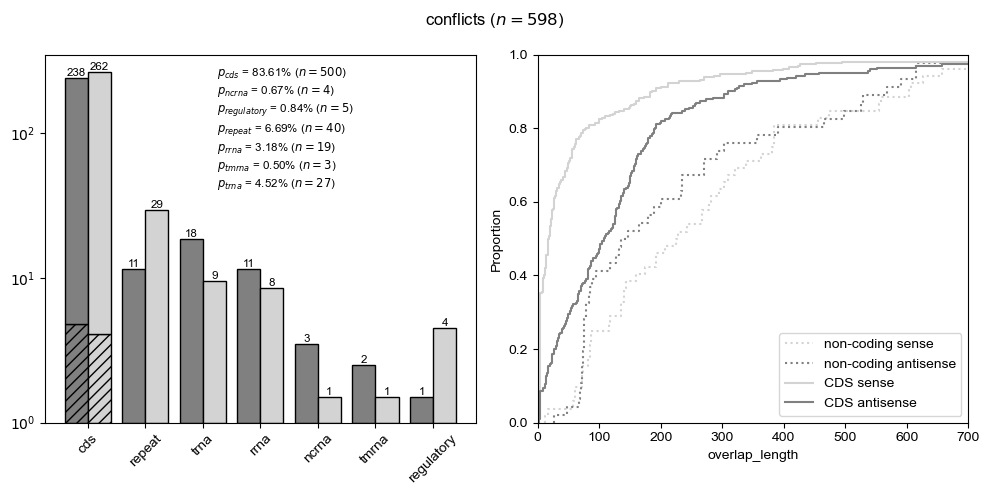

In [12]:
def si_figure(dataset_df:pd.DataFrame):

    figure_df = dataset_df[dataset_df.conflict].copy()
    
    masks = dict()
    masks['cds'] = figure_df.top_hit_feature == 'CDS'
    masks['trna'] = figure_df.top_hit_feature == 'tRNA'
    masks['rrna'] = figure_df.top_hit_feature == 'rRNA'
    masks['tmrna'] = figure_df.top_hit_feature == 'tmRNA'
    masks['ncrna'] = figure_df.top_hit_feature == 'ncRNA'
    masks['repeat'] = figure_df.top_hit_feature == 'repeat_region'
    masks['regulatory'] = figure_df.top_hit_feature == 'regulatory'

    categories = ['cds', 'repeat', 'trna', 'rrna', 'ncrna',  'tmrna', 'regulatory']
    conditions = [masks[category] for category in categories]
    figure_df['category'] = np.select(conditions, categories, default='none')

    fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2) #, width_ratios=[0.6, 0.4])
    
    width = 0.4
    offsets = {True:width/2, False:-width/2}
    palette = {True:'lightgray', False:'gray'}
        
    positions = np.arange(figure_df.category.nunique())

    for same_strand, df in figure_df.groupby('same_strand'):
        ax_a_df = pd.DataFrame(index=categories)
        ax_a_df['total'] = df.category.value_counts()
        ax_a_df['log_total'] = np.log10(ax_a_df['total'] + 0.5)
        ax_a_df['fraction'] = df.groupby('category').apply(lambda df : df.top_hit_unsupported.sum() / len(df), include_groups=False)
        ax_a_df['unsupported'] = ax_a_df['log_total'] * ax_a_df['fraction']
        ax_a_df['supported'] = ax_a_df['log_total'] * (1 - ax_a_df['fraction'])

        ax_a.bar(positions + offsets[same_strand], ax_a_df.unsupported, color=palette[same_strand], edgecolor='black', hatch='///', width=width)
        ax_a.bar(positions + offsets[same_strand], ax_a_df.supported, bottom=ax_a_df.unsupported, color=palette[same_strand], edgecolor='black', width=width)
        
        for x, total, log_total in zip(positions + offsets[same_strand], ax_a_df.total, ax_a_df.log_total):
            # text = f'{100 * total / ax_a_df.total.sum():.2f}%'
            text = str(total)
            ax_a.text(x, log_total, text, ha='center', fontsize='small', va='bottom')

    ax_a.set_xticks(positions, labels=ax_a_df.index, rotation=45)
    ax_a.set_yticks(np.arange(3), labels=[f'$10^{i}$' for i in range(3)])

    text = ''
    for category, df in figure_df.groupby('category'):
        text += '$p_{' + category + '}$' + f' = {get_percent(len(df), len(figure_df))} ($n={len(df)}$)\n'
    ax_a.text(0.4, 0.6, text, transform=ax_a.transAxes, fontsize='small')

    sns.ecdfplot(figure_df[is_non_coding_conflict(figure_df) & figure_df.same_strand], x='overlap_length', color=palette[True], ax=ax_b, ls=':', label='non-coding sense')
    sns.ecdfplot(figure_df[is_non_coding_conflict(figure_df) & ~figure_df.same_strand], x='overlap_length', color=palette[False], ax=ax_b, ls=':', label='non-coding antisense')
    sns.ecdfplot(figure_df[is_cds_conflict(figure_df) & figure_df.same_strand], x='overlap_length', color=palette[True], ax=ax_b, label='CDS sense')
    sns.ecdfplot(figure_df[is_cds_conflict(figure_df) & ~figure_df.same_strand], x='overlap_length', color=palette[False], ax=ax_b, label='CDS antisense')
    ax_b.legend()
    ax_b.set_xlim(xmin=0, xmax=700)

    fig.suptitle(f'conflicts ($n={len(figure_df)}$)')
    fig.tight_layout()
    plt.show()

si_figure(dataset_df)

In [6]:
print('Num. conflicts with non-coding elements:', is_non_coding_conflict(dataset_df).sum())
print('Num. nested conflicts with non-coding elements:', (is_non_coding_conflict(dataset_df) & (dataset_df.overlap_type == 'nested')).sum())
print('Num. conflicts with non-coding elements where the query is completely contained within the non-coding gene:', (is_non_coding_conflict(dataset_df) & (dataset_df.query_overlap_fraction == 1)).sum())
print('Num. conflicts with non-coding elements where the non-coding gene is completely contained within the query:', (is_non_coding_conflict(dataset_df) & (dataset_df.top_hit_overlap_fraction == 1)).sum())

Num. conflicts with non-coding elements: 98
Num. nested conflicts with non-coding elements: 82
Num. conflicts with non-coding elements where the query is completely contained within the non-coding gene: 55
Num. conflicts with non-coding elements where the non-coding gene is completely contained within the query: 27


In [42]:
# print('Num. sequences which conflict with > 1 reference element:', ((dataset_df.conflict) & (dataset_df.n_hits > 1)).sum())
# print('Num. sequences which conflict with > 2 reference elements:', ((dataset_df.conflict) & (dataset_df.n_hits > 2)).sum(), end='\n\n')

# conflict_ids = dataset_df[(dataset_df.conflict) & (dataset_df.top_hit_feature == 'CDS') & (dataset_df.n_hits > 1)].index

# # Seems as though all but two sequences only conflict with other CDS. I think these can mostly be ignored, but probably an increased likelihood
# # that these sequences are spurious. 
# for id_, df in all_hits_df[all_hits_df.query_id.isin(conflict_ids)].groupby('query_id'):
#     if not np.all(df.subject_feature == 'CDS'):
#         print(f'Expected all conflicts to be with CDS, but {id_} conflicts with: ' + ', '.join(df.subject_feature))
#     if not np.all(df.conflict): # Making sure no matches snuck in. 
#         print(f'Expected all conflicting sequences to only conflict with the reference, but {id_} has hits annotated as: ' + ', '.join(df.category))


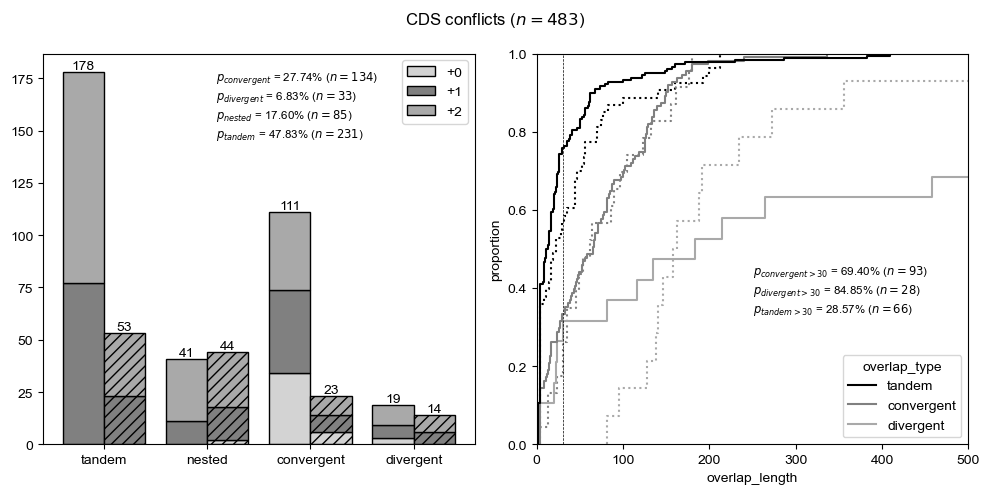

In [130]:
# TODO: Check the overlap lengths for different frames. 

def si_figure_2(dataset_df:pd.DataFrame, exclude_nested:bool=False):
    figure_df = dataset_df[is_cds_conflict(dataset_df)].copy()
    figure_df = figure_df[figure_df.overlap_type].copy() if exclude_nested else figure_df
    
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    figure_df['phase'] = ['+' + str(int(row.phase)) for row in figure_df.itertuples()]

    palette = {'+0':'lightgray', '+1':'gray', '+2':'darkgray', 'none':'white'}
    overlap_types = figure_df.overlap_type.unique()
    positions = np.arange(len(overlap_types))
    width = 0.4

    def panel_a(ax_df:pd.DataFrame, offset:float=None, hatch=None, add_label:bool=True):
        totals =  np.zeros(len(overlap_types))
        bottom = np.zeros(len(overlap_types))
        for phase, df in ax_df.groupby('phase'):
            heights = [(df.overlap_type == overlap_type).sum() for overlap_type in overlap_types]
            ax_a.bar(positions + offset, heights, bottom=bottom, edgecolor='black', label=phase if add_label else None, color=palette[phase], width=width, hatch=hatch)
            bottom += np.array(heights)
            totals += heights
        for x, y in zip(positions + offset, totals):
            ax_a.text(x, y, str(int(y)), ha='center', va='bottom')

    panel_a(figure_df[~figure_df.top_hit_unsupported], offset=-width/2)
    panel_a(figure_df[figure_df.top_hit_unsupported], offset=width/2, hatch='///', add_label=False)

    text = ''
    for overlap_type, df in figure_df.groupby('overlap_type'):
        text += '$p_{' + overlap_type + '}$' + f' = {get_percent(len(df), len(figure_df))} ($n={len(df)}$)\n'
    ax_a.text(0.4, 0.75, text, transform=ax_a.transAxes, fontsize='small')

    ax_a.set_xticks(positions, labels=overlap_types)
    ax_a.legend()

    ax_b_df = figure_df[figure_df.overlap_type != 'nested'].copy()

    palette = {'tandem':'black', 'convergent':'gray', 'divergent':'darkgray'}
    sns.ecdfplot(data=ax_b_df[ax_b_df.top_hit_unsupported], x='overlap_length', hue='overlap_type', ls=':', palette=palette, ax=ax_b)
    sns.ecdfplot(data=ax_b_df[~ax_b_df.top_hit_unsupported], x='overlap_length', hue='overlap_type', palette=palette, ax=ax_b)
    ax_b.set_xlim(xmin=0, xmax=500)
    ax_b.set_ylabel('proportion')

    overlap_length, text = 30, ''
    for overlap_type, df in ax_b_df.groupby('overlap_type'):
        n = (df.overlap_length > overlap_length).sum()
        text += '$p_{' + overlap_type + '>' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
    ax_b.text(0.5, 0.3, text, transform=ax_b.transAxes, fontsize='small')
    ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

    fig.suptitle(f'CDS conflicts ($n={len(figure_df)}$)')
    fig.tight_layout()
    plt.show()

# si_figure_2(dataset_df, exclude_nested=True)
si_figure_2(dataset_df, exclude_nested=False)

{'+1 (43.48%)': 'lightgray', '+2 (56.52%)': 'darkgray'}
{'+0 (25.75%)': 'lightgray', '+1 (35.93%)': 'darkgray', '+2 (38.32%)': 'gray'}
Num. tandem overlaps > 7 bp in phase 1: 100
Num. tandem overlaps > 7 bp in phase 2: 38
Num. antiparallel overlaps > 7 bp in phase 0: 43
Num. antiparallel overlaps > 7 bp in phase 1: 41
Num. antiparallel overlaps > 7 bp in phase 2: 64


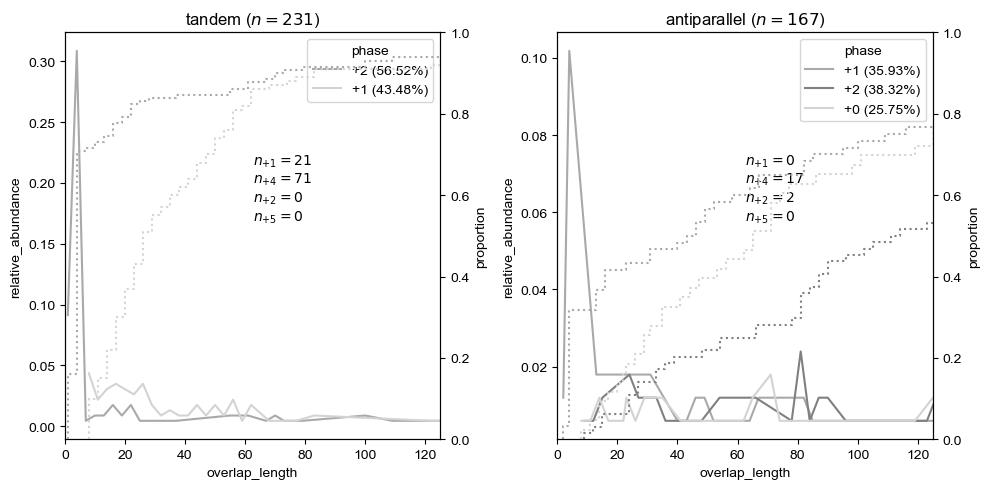

In [ ]:
def si_figure(dataset_df:pd.DataFrame, supported:bool=None):
     
    if supported is not None:
        figure_df = dataset_df[is_supported_cds_conflict(dataset_df)].copy() if supported else dataset_df[is_unsupported_cds_conflict(dataset_df)].copy()
    else:
        figure_df = dataset_df[is_cds_conflict(dataset_df)].copy()

    figure_df = figure_df[figure_df.overlap_type != 'nested'].copy()
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)

    titles = {True:f'tandem ($n={figure_df.same_strand.sum()}$)', False:f'antiparallel ($n={(~figure_df.same_strand).sum()}$)'}

    for ax, same_strand in zip(axes, [True, False]):
        ax_df = figure_df[figure_df.same_strand == same_strand].copy()
        ax_df = ax_df[ax_df.index != 'NZ_FAOO01000018.1_5'] # One of the tandem overlaps is +0 because the top hit is partial, and the query has a ton of X's in the middle.
        phase_counts = ax_df.phase.value_counts().to_dict()
        ax_df['phase'] = [f'+{int(phase)} ({get_percent(phase_counts[phase], len(ax_df))})' for phase in ax_df.phase]

        palette = {label:['lightgray', 'darkgray', 'gray'][i] for i, label in enumerate(sorted(ax_df.phase.unique()))}
        ax_ = sns.ecdfplot(ax_df, x='overlap_length', hue='phase', palette=palette, ls=':', ax=ax.twinx(), legend=False)
        ax_.set_ylabel('proportion')

        phase_map = {overlap_length:phase for overlap_length, phase in zip(ax_df.overlap_length, ax_df.phase)}
        ax_df = ax_df.overlap_length.value_counts().reset_index()
        ax_df['phase'] = ax_df.overlap_length.map(phase_map)
        ax_df['relative_abundance'] = ax_df['count'] / ax_df['count'].sum()

        sns.lineplot(ax_df, x='overlap_length', y='relative_abundance', hue='phase', palette=palette, ax=ax)

        text = ''
        for overlap_length in [1, 4, 2, 5]:
            n = ax_df[ax_df.overlap_length == overlap_length]['count']
            n = 0 if len(n) == 0 else n.iloc[0]
            text += '$n_{+' + str(overlap_length) + '} = ' + str(n) + '$\n'
        ax.text(0.5, 0.5, text, transform=ax.transAxes)
        ax.set_title(titles[same_strand])

        ax.set_xlim(xmin=0, xmax=125)

    fig.tight_layout()

si_figure(dataset_df, supported=None)

print('Num. tandem overlaps > 7 bp in phase 1:', (is_cds_conflict(dataset_df) & (dataset_df.overlap_type == 'tandem') & (dataset_df.phase == 1) & (dataset_df.overlap_length > 7)).sum())
print('Num. tandem overlaps > 7 bp in phase 2:', (is_cds_conflict(dataset_df) & (dataset_df.overlap_type == 'tandem') & (dataset_df.phase == 2) & (dataset_df.overlap_length > 7)).sum())

print('Num. antiparallel overlaps > 7 bp in phase 0:', (is_cds_conflict(dataset_df) & (dataset_df.overlap_type.isin(['convergent', 'divergent'])) & (dataset_df.phase == 0) & (dataset_df.overlap_length > 7)).sum())
print('Num. antiparallel overlaps > 7 bp in phase 1:', (is_cds_conflict(dataset_df) & (dataset_df.overlap_type.isin(['convergent', 'divergent'])) & (dataset_df.phase == 1) & (dataset_df.overlap_length > 7)).sum())
print('Num. antiparallel overlaps > 7 bp in phase 2:', (is_cds_conflict(dataset_df) & (dataset_df.overlap_type.isin(['convergent', 'divergent'])) & (dataset_df.phase == 2) & (dataset_df.overlap_length > 7)).sum())

In [11]:
# Overlaps greater than 60 bp are almost certainly spurious. However, the proteins could still be in-frame with a genuine ORF, and the 
# overlap may be the result of a boundary error. Sequences can be extended at the N-terminus due to erroneous start-codon selection, or extended 
# at the C-terminus due to a frameshift mutation. N-terminal extensions are the most common cause of overlap, and also the simplest to detect, 
# so will probably limit analysis to these. 

# Conflicts that are potentially the result of N-terminal extension include:
# (1) Divergent overlaps where one or both sequence coordinates are the product of ab initio prediction. 
# (2) Tandem overlaps where the downstream sequence coordinates are the product of ab initio prediction. 
# (2) Nested overlaps where one or both sequence coordinates are the product of ab initio prediction. 

In [ ]:
# is_partial_at_c_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == -1) or ((partial[-1] == '1') and (strand == 1))
# is_partial_at_n_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == 1) or ((partial[-1] == '1') and (strand == -1))

# is_query_partial_at_c_terminus = lambda row : is_partial_at_c_terminus(row.query_strand, row.query_partial)
# is_top_hit_cds = lambda row : (row.top_hit_feature == 'CDS') and not row.top_hit_pseudo

# query_start_in_top_hit = lambda df : (df.query_start <= df.top_hit_stop) & (df.query_start >= df.top_hit_start)
# query_stop_in_top_hit = lambda df : (df.query_stop <= df.top_hit_stop) & (df.query_stop >= df.top_hit_start)
# is_conflict_at_query_n_terminus = lambda df : (df.query_strand == 1) & query_start_in_top_hit(df) | ((df.query_strand == -1) & query_stop_in_top_hit(df))

# has_overlap = lambda row : not ((row.query_stop < row.top_hit_start) or (row.query_start > row.top_hit_stop))
# get_overlap_length = lambda row : 0 if not has_overlap(row) else min(row.query_stop, row.top_hit_stop) - max(row.query_start, row.top_hit_start)
# get_overlap_type = lambda row : reference.get_overlap_type(query_start=row.query_start, query_stop=row.query_stop, subject_start=row.top_hit_start, subject_stop=row.top_hit_stop, query_strand=row.query_strand, subject_strand=row.top_hit_strand)

# is_conflict_from_n_terminal_extension = lambda df : df.conflict & (is_conflict_at_query_n_terminus(df))


In [109]:
# repaired_conflict_ids = repaired_dataset_df.index.values

# print('Num. repaired conflicts:', len(repaired_dataset_df))
# print('Num. repaired conflicts with non-coding elements:', is_non_coding_conflict(repaired_dataset_df).sum())
# print('Num. repaired conflicts with CDS:', is_cds_conflict(repaired_dataset_df).sum())
# print('Num. repaired tandem conflicts:', (is_cds_conflict(repaired_dataset_df) & (repaired_dataset_df.original_overlap_type == 'tandem')).sum())
# print('Num. repaired divergent conflicts:', (is_cds_conflict(repaired_dataset_df) & (repaired_dataset_df.original_overlap_type == 'divergent')).sum())
# print('Num. repaired nested conflicts:', (is_cds_conflict(repaired_dataset_df) & (repaired_dataset_df.original_overlap_type == 'nested')).sum())

In [128]:
# All but three of the non-coding conflicts are predicted to be spurious. What are the characteristics of the ones which are predicted to be real with high confidence?
for row in results_df[is_non_coding_conflict(results_df) & (results_df.model_label != 'spurious')].itertuples():
    print(row.Index, f'{row.model_label}, {row.model_output_1 * 100:.2f}% confidence')
    print(f'top_hit_feature: {row.top_hit_feature}')
    print(f'top_hit_note: {row.top_hit_note}')
    print('same_strand:', row.same_strand, 'query_strand:', row.query_strand)
    print('overlap_length:', row.overlap_length, f'{row.query_overlap_fraction * 100:.2f}% of query')
    print(f'genome: {row.genome_id}, on contig {row.top_hit_contig_id}, ({row.query_start}, {row.query_stop})')
    print()

NZ_NIGF01000030.1_1 uncertain, 10.26% confidence
top_hit_feature: rRNA
top_hit_note: Derived by automated computational analysis using gene prediction method: cmsearch.
same_strand: True query_strand: 1
overlap_length: 117 20.10% of query
genome: GCF_002973605.1, on contig NZ_NIGF01000030, (2, 583)

NZ_CP018099.1_801 real, 100.00% confidence
top_hit_feature: rRNA
top_hit_note: Derived by automated computational analysis using gene prediction method: cmsearch.
same_strand: True query_strand: 1
overlap_length: 363 100.00% of query
genome: GCF_001886815.1, on contig NZ_CP018099, (1052956, 1053318)

NZ_QXIU01000193.1_1 real, 98.35% confidence
top_hit_feature: regulatory
top_hit_note: molybdenum cofactor riboswitch; Derived by automated computational analysis using gene prediction method: cmsearch.
same_strand: True query_strand: -1
overlap_length: 11 6.43% of query
genome: GCF_003570935.1, on contig NZ_QXIU01000193, (2, 172)



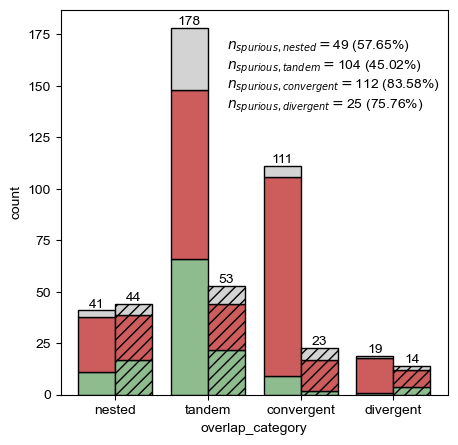

In [110]:
def figure(results_df:pd.DataFrame):
    figure_df = results_df[is_cds_conflict(results_df)].copy()

    fig, ax = plt.subplots(figsize=(5, 5))
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}
    overlap_types = figure_df.overlap_type.unique()
    positions = np.arange(len(overlap_types))
    width = 0.4

    def panel_a(ax_df:pd.DataFrame, offset:float=None, hatch=None, add_label:bool=True):
        totals =  np.zeros(len(overlap_types))
        bottom = np.zeros(len(overlap_types))
        for model_label, df in ax_df.groupby('model_label'):
            heights = [(df.overlap_type == overlap_type).sum() for overlap_type in overlap_types]
            ax.bar(positions + offset, heights, bottom=bottom, edgecolor='black', label=model_label if add_label else '', color=palette[model_label], width=width, hatch=hatch, )
            bottom += np.array(heights)
            totals += heights
        for x, y in zip(positions + offset, totals):
            ax.text(x, y, str(int(y)), ha='center', va='bottom')

    panel_a(figure_df[~figure_df.top_hit_unsupported], offset=-width/2)
    panel_a(figure_df[figure_df.top_hit_unsupported], offset=width/2, hatch='///', add_label=False)
    ax.set_xticks(positions, labels=overlap_types)
    ax.set_ylabel('count')
    ax.set_xlabel('overlap_category')

    text = ''
    for category in ['nested', 'tandem', 'convergent', 'divergent']:
        n = ((figure_df.overlap_type == category) & (figure_df.spurious)).sum()
        text += '$n_{spurious,' + category + '}=$' + str(n) + f' ({get_percent(n, (figure_df.overlap_type == category).sum())})'  + '\n'
    ax.text(0.43, 0.7, text, transform=ax.transAxes)

    plt.show()


figure(results_df)

In [108]:
table_df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'nested')].copy()
table_df['query_nested'] = table_df.query_overlap_fraction == 1
table_df['smorf'] = table_df.length < 100
# table_df = table_df[table_df.phase != 0].copy()

# query_nested and top_hit_match don't seem to have a huge effect on either strand. 

# variables = ['same_strand', 'top_hit_unsupported', 'phase', 'query_nested', 'smorf']
variables = ['top_hit_unsupported', 'phase', 'query_nested', 'smorf']
table_df = table_df[~table_df.same_strand].copy() # Control for strand.
table_df = table_df[table_df.model_label != 'uncertain']

for variable in variables:
    print(variable)
    # If the variable has no effect on the label, then 
    observed_counts_df = pd.crosstab(table_df[variable], table_df['model_label'])
    totals = observed_counts_df.sum(axis=1)
    # Not sure if I should be testing for independence, or using the null that they are equally-distributed. 
    # expected_counts_df = pd.DataFrame(0.5, index=observed_counts_df.index, columns=observed_counts_df.columns)
    # expected_counts_df = expected_counts_df.mul(totals, axis=0)
    expected_counts_df = pd.DataFrame(expected_freq(observed_counts_df), index=observed_counts_df.index, columns=observed_counts_df.columns) # This uses frequencies based on the marginal frequencies.
    p = chisquare(observed_counts_df.values.ravel(), expected_counts_df.values.ravel()).pvalue
    print(f'p={p}')
    print()

top_hit_unsupported
p=0.013842854426955884

phase
p=0.5433938585521862

query_nested
p=0.6163000223149475

smorf
p=0.9995381795534792



In [303]:
blast_df = BLASTJsonFile('../data/results/results-2/antiparallel_real_blast.json').to_df()
blast_df = blast_df[blast_df.bit_score > 50].copy()
blast_df = blast_df.sort_values('bit_score', ascending=False)
# blast_df = blast_df[blast_df.query_seq != blast_df.subject_seq].copy() # Remove the cases where the BLAST alignment is just to the sequence itself.
blast_df = blast_df[np.array([id_.split('.')[0] for id_ in blast_df.index]) != blast_df.subject_id].copy() # Remove the cases where the BLAST alignment is just to the sequence itself.

interpro_df = InterProScanFile('../data/results/results-2/antiparallel_real_interpro.tsv').to_df()
df['interpro_hit'] = df.index.isin(interpro_df.index)
df['top_hit_interpro_hit'] = df.top_hit_protein_id.isin(interpro_df.index)

In [341]:
# spans_assembly_gap = lambda df : df.apply(lambda row : re.search(r'X{5,}', row.seq) is not None, axis=1)
# df = results_df[spans_assembly_gap(results_df)].copy()
results_df['n_unknown_amino_acids'] = results_df.seq.str.count('X')
results_df['fraction_unknown_amino_acids'] = results_df.n_unknown_amino_acids / results_df.length 
results_df['effective_length'] = results_df.length - results_df.n_unknown_amino_acids
(results_df.fraction_unknown_amino_acids > 0).sum()
results_df['spans_assembly_gap'] = results_df.fraction_unknown_amino_acids > 0.5
# results_df[results_df.spans_assembly_gap].model_label.value_counts()
results_df[results_df.spans_assembly_gap][['category', 'length', 'n_unknown_amino_acids', 'model_label', 'model_output_1', 'top_hit_note', 'effective_length']]

,category,length,n_unknown_amino_acids,model_label,model_output_1,top_hit_note,effective_length
id,,,,,,,
NC_021487.1_1505,intergenic,1911,1853,real,1.000000,none,58
NC_021487.1_783,conflict,869,842,real,1.000000,Derived by automated computational analysis us...,27
NC_021487.1_1788,conflict,750,573,real,0.999862,Derived by automated computational analysis us...,177
NZ_FAOO01000001.1_11,match,362,227,real,0.999975,Derived by automated computational analysis us...,135
NZ_FAOO01000011.1_24,pseudogene,342,177,real,0.991136,incomplete; too short partial abutting assembl...,165
NZ_FAOO01000003.1_167,pseudogene,313,207,real,0.999981,incomplete; too short partial abutting assembl...,106
NZ_FAOO01000003.1_33,match,309,190,real,0.999997,Derived by automated computational analysis us...,119
NZ_FAOO01000009.1_75,match,308,189,real,0.999908,Derived by automated computational analysis us...,119
NZ_FAOO01000008.1_21,match,268,185,real,0.993788,Derived by automated computational analysis us...,83


In [342]:
from transformers import EsmTokenizer 
tokenizer = EsmTokenizer.from_pretrained('facebook/esm2_t30_150M_UR50D')

In [344]:
tokenizer('GLXXXXLGGCGFRGGFGLGLFPWRSTPTLRCDN')

{'input_ids': [0, 6, 4, 24, 24, 24, 24, 4, 6, 6, 23, 6, 18, 10, 6, 6, 18, 6, 4, 6, 4, 18, 14, 22, 10, 8, 11, 14, 11, 4, 10, 23, 13, 17, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [307]:
len('SGRFSKTMMIWRGHFLSCAHNFVWVYQTVMQRLDTDRGRWGSGLLGGCGFRGGFGLGLFPWRSTPTLRCDNAKALGHTQGSLPEAPEIQTPLKANALLLKADTGAPRKSCDFLGAGRPSPHSYPTSCLAYLGSSPSSPA')

139

In [296]:
top_hit_ids = df.top_hit_protein_id.unique()
ids = df.index

n_top_hits_with_no_blast_hit = (~np.isin(top_hit_ids, blast_df.index.unique())).sum()
n_with_no_blast_hit = (~np.isin(ids, blast_df.index.unique())).sum()

print(n_top_hits_with_no_blast_hit)
print(n_with_no_blast_hit)

get_n_blast_hits = lambda df : df.index.value_counts()
get_n_blast_hits(blast_df.loc[np.intersect1d(top_hit_ids, blast_df.index)])
# blast_df[~blast_df.index.duplicated()].loc[np.intersect1d(ids, blast_df.index)]

5
4


id
WP_219916526.1    132
WP_235894651.1    109
WP_016482166.1    100
WP_323219879.1    100
WP_140945916.1     99
WP_317995701.1     99
WP_181180363.1     99
WP_323218034.1     99
WP_259091938.1     99
WP_016483150.1      7
WP_218112099.1      1
Name: count, dtype: int64

In [297]:
# Might be good to take a closer look at the antiparallel-conflicting proteins predicted to be real with high confidence.
# There are too many spurious predictions to look at in any depth. 

df = results_df[is_antiparallel_cds_conflict(results_df) & results_df.real].copy()

n_hypothetical = (df.top_hit_product != 'hypothetical protein').sum()
n_unsupported = ((df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type == 'ab initio prediction')).sum()

print('Num. real-predicted antiparallel conflicts with hypothetical proteins:', n_hypothetical, f'({get_percent(n_hypothetical, len(df))})')
print('Num. real-predicted antiparallel conflicts with unsupported proteins:', n_unsupported, f'({get_percent(n_unsupported, len(df))})')

for overlap_type in ['divergent', 'convergent']:
    n_hypothetical = ((df.top_hit_product != 'hypothetical protein') & (df.overlap_type == overlap_type)).sum()
    n_unsupported = ((df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type == 'ab initio prediction') & (df.overlap_type == overlap_type)).sum()

    print(f'\nNum. real-predicted {overlap_type} conflicts with hypothetical proteins:', n_hypothetical, f'({get_percent(n_hypothetical, (df.overlap_type == overlap_type).sum())})')
    print(f'Num. real-predicted {overlap_type} conflicts with unsupported proteins:', n_unsupported, f'({get_percent(n_unsupported, (df.overlap_type == overlap_type).sum())})')

# df[df.top_hit_product != 'hypothetical protein'][['top_hit_protein_id', 'top_hit_product', 'length', 'query_start', 'query_stop', 'genome_id', 'overlap_length', 'species', 'overlap_type', 'phase']]
columns = ['species', 'genome_id', 'top_hit_protein_id', 'top_hit_product', 'top_hit_evidence_type', 'phase', 'length', 'top_hit_length', 'overlap_length', 'spans_assembly_gap', 'overlap_type']
df['spans_assembly_gap'] = df.seq.str.count('X') > 2
df[columns].to_csv('../data/results/results-2/antiparallel_real.csv')

import re
content = ''
for row in df.itertuples():
    seq = re.sub('X{2,}', '', row.seq)
    content += f'>{row.Index}\n{seq}\n'
    content += f'>{row.top_hit_protein_id}\n{row.top_hit_seq}\n'
with open('../data/results/results-2/antiparallel_real.faa', 'w') as f:
    f.write(content)

# pd.crosstab(df.overlap_type, df.phase)
# df[df.spans_assembly_gap]

Num. real-predicted antiparallel conflicts with hypothetical proteins: 9 (56.25%)
Num. real-predicted antiparallel conflicts with unsupported proteins: 6 (37.50%)

Num. real-predicted divergent conflicts with hypothetical proteins: 1 (20.00%)
Num. real-predicted divergent conflicts with unsupported proteins: 4 (80.00%)

Num. real-predicted convergent conflicts with hypothetical proteins: 8 (72.73%)
Num. real-predicted convergent conflicts with unsupported proteins: 2 (18.18%)


In [300]:
df[['overlap_type', 'query_partial']]

,overlap_type,query_partial
id,,
NC_021487.1_1788,convergent,00
NZ_JAYGHR010000004.1_79,convergent,00
NZ_JAIKTU010000018.1_22,divergent,00
NZ_FAOO01000001.1_107,convergent,00
NZ_FAOO01000031.1_5,divergent,00
NC_021487.1_766,convergent,00
NZ_CP065383.1_54,divergent,00
NZ_CP130454.1_2808,convergent,00
NZ_NIGF01000005.1_153,divergent,00


In [204]:
def get_chi_square_p_value(observed_counts_df:pd.DataFrame):
    totals = observed_counts_df.sum(axis=1)
    # Not sure if I should be testing for independence, or using the null that they are equally-distributed. 
    expected_counts_df = pd.DataFrame(0.5, index=observed_counts_df.index, columns=observed_counts_df.columns)
    expected_counts_df = expected_counts_df.mul(totals, axis=0)
    # expected_counts_df = pd.DataFrame(expected_freq(observed_counts_df), index=observed_counts_df.index, columns=observed_counts_df.columns) # This uses frequencies based on the marginal frequencies.
    p = chisquare(observed_counts_df.values.ravel(), expected_counts_df.values.ravel()).pvalue
    return p

p=0.0017450059973222805
p=0.0017450059973222805


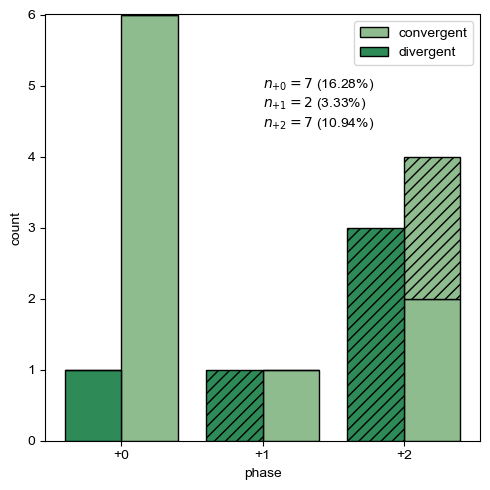

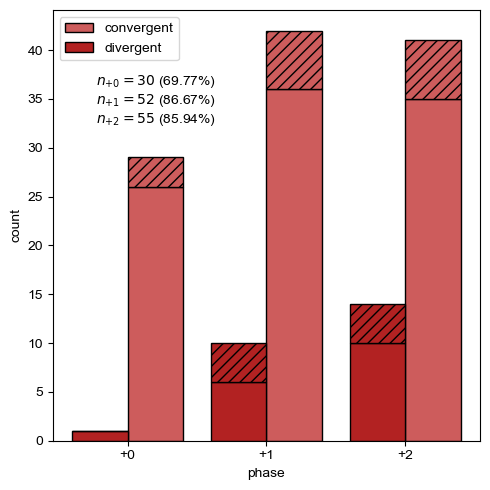

In [224]:
def si_figure(results_df:pd.DataFrame, model_label:str='real', text_position=(0.1, 0.7)):

    fig, ax = plt.subplots(figsize=(5, 5))

    palettes = {'real':{'convergent':'darkseagreen', 'divergent':'seagreen'}, 'spurious':{'convergent':'indianred', 'divergent':'firebrick'}}

    figure_df = results_df[is_antiparallel_cds_conflict(results_df)].copy()
    phases = sorted(figure_df.phase.unique())
    totals = figure_df.phase.value_counts().loc[phases].values 

    p = get_chi_square_p_value(pd.crosstab(table_df['phase'], table_df['model_label']))
    print(f'p={p}')
    figure_df = figure_df[figure_df.model_label == model_label].copy()

    width = 0.4 
    palette = palettes[model_label]
    positions = np.arange(len(phases))
    offsets = {'convergent': width / 2, 'divergent':-width / 2}
    hatches = {True:'///', False:None}

    def panel(ax_df:pd.DataFrame, offset:float=None, color:str=None, ax:plt.Axes=None, label:str=None, bottom=np.zeros(len(phases))):
        for top_hit_unsupported, df in ax_df.groupby('top_hit_unsupported'):
            heights = np.array([((df.phase == phase)).sum() for phase in phases])
            ax.bar(positions + offset, heights, bottom=bottom, color=color, hatch=hatches[top_hit_unsupported], edgecolor='black', width=width, label=label if (not top_hit_unsupported) else None)
            bottom += heights 
        return bottom

    for overlap_type in ['convergent', 'divergent']:
        ax_df = figure_df[(figure_df.overlap_type == overlap_type)].copy()
        panel(ax_df, offset=offsets[overlap_type], label=overlap_type, ax=ax, color=palette[overlap_type], bottom=np.zeros(len(phases)))

    text = ''
    for i, n in enumerate(figure_df.phase.value_counts().loc[phases].values):
        text += '$n_{' + f'+{int(i)}' + '}' + f'={n}$ ({get_percent(n, totals[i])})\n'
    # ax.text(0.35, 0.8, text, transform=ax.transAxes)
    ax.text(*text_position, text, transform=ax.transAxes)

    ax.legend()
    ax.set_xticks(positions, labels=[f'+{int(phase)}' for phase in phases])
    ax.set_xlabel('phase')
    ax.set_ylabel('count')

    fig.tight_layout()

si_figure(results_df, model_label='real', text_position=(0.5, 0.7))
si_figure(results_df, model_label='spurious', text_position=(0.1, 0.7))

In [21]:
# figure_df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'tandem')].copy()
# figure_df['query_overlap_fraction_bin'] = pd.cut(figure_df.query_overlap_fraction, bins=np.arange(0, 1.1, 0.1), retbins=False, labels=False)
# fig, ax = plt.subplots(figsize=(5, 5))

# ax_df = pd.DataFrame(index=figure_df.query_overlap_fraction_bin.unique())
# ax_df['n_real'] = ax_df.index.map(figure_df.groupby('query_overlap_fraction_bin').real.sum())
# ax_df['n_spurious'] = ax_df.index.map(figure_df.groupby('query_overlap_fraction_bin').spurious.sum())
# ax_df['n_uncertain'] = ax_df.index.map(figure_df.groupby('query_overlap_fraction_bin').uncertain.sum())
# ax_df['total'] = ax_df.index.map(figure_df.groupby('query_overlap_fraction_bin').apply(len, include_groups=False))

# for col in ['n_real', 'n_spurious', 'n_uncertain']:
#     ax_df[col.replace('n_', 'frac_')] = ax_df[col] / ax_df['total']
# ax_df['bin'] = ax_df.index

# sns.lineplot(ax_df, y='frac_real', x='bin', color='darkseagreen', label='real')
# sns.lineplot(ax_df, y='frac_spurious', x='bin', color='indianred', label='spurious')
# sns.lineplot(ax_df, y='frac_uncertain', x='bin', color='lightgray', label='uncertain')
# ax.set_xticks(np.arange(len(np.arange(0, 1, 0.1))), labels=[f'{n:.1f}' for n in np.arange(0, 1, 0.1)])
# ax.set_xlabel('query_overlap_fraction')
# ax.set_ylabel('fraction')
# plt.show()

In [ ]:
# figure_df = results_df[is_cds_conflict(results_df)].copy()
# figure_df['top_hit_match'] = figure_df.top_hit_match.astype(bool)
# figure_df['top_hit_exact_match'] = figure_df.top_hit_exact_match.astype(bool)
# figure_df['hypothetical'] = is_hypothetical_cds_conflict(figure_df)

# fig, ax = plt.subplots(figsize=(5, 5))

# ax_df = figure_df[(figure_df.overlap_type == 'convergent')].copy()
# sns.ecdfplot(data=ax_df[~ax_df.top_hit_exact_match], x='overlap_length', ls=':', color='darkgray')
# sns.ecdfplot(data=ax_df[ax_df.top_hit_exact_match], x='overlap_length', color='darkgray')
# sns.ecdfplot(data=ax_df[ax_df.hypothetical], x='overlap_length', color='lightgray')

# print('Num. undetected conflicts:', (~figure_df.top_hit_exact_match & (figure_df.overlap_type == 'convergent')).sum())
# print('Num. detected conflicts:', (figure_df.top_hit_exact_match & (figure_df.overlap_type == 'convergent')).sum())
# # sns.ecdfplot(data=figure_df[~figure_df.top_hit_exact_match & (figure_df.overlap_type == 'tandem')], x='overlap_length', ls=':', color='black')
# # sns.ecdfplot(data=figure_df[figure_df.top_hit_exact_match & (figure_df.overlap_type == 'tandem')], x='overlap_length', color='black')

# ax.axvline(x=60, color='black', ls='--', lw=0.5)
# ax.axvline(x=100, color='black', ls='--', lw=0.5)

# text = ''
# for exact_match, df in ax_df.groupby('top_hit_exact_match'):
#     n = (df.overlap_length > 100).sum()
#     label = 'exact' if exact_match else 'none'
#     text += '$p_{' + label + '>' + str(100) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
# n = (ax_df.hypothetical & (ax_df.overlap_length > 100)).sum()
# text += '$p_{hypothetical >' + str(100) + '}$' + f' = {get_percent(n, ax_df.hypothetical.sum())} ($n={n}$)\n'
# ax.text(0.5, 0.3, text, transform=ax.transAxes, fontsize='small')

# ax.set_xlim(xmin=0, xmax=200)
# ax.set_ylabel('proportion')

# # Half of all convergent overlaps predicted by Prodigal are < 60 bp, and half of all convergent overlaps not predicted by Prodigal are < 60 bp. 
# # Basically, the ratio of detected to undetected conflicts declines after 60 bp. 

Num. real tandem +1 overlaps: 7 (7.95%)
Num. real tandem +4 overlaps: 35 (39.77%)
Num. real tandem phase +1 overlaps: 29 (32.95%)
Num. real tandem phase +2 overlaps: 59 (67.05%)


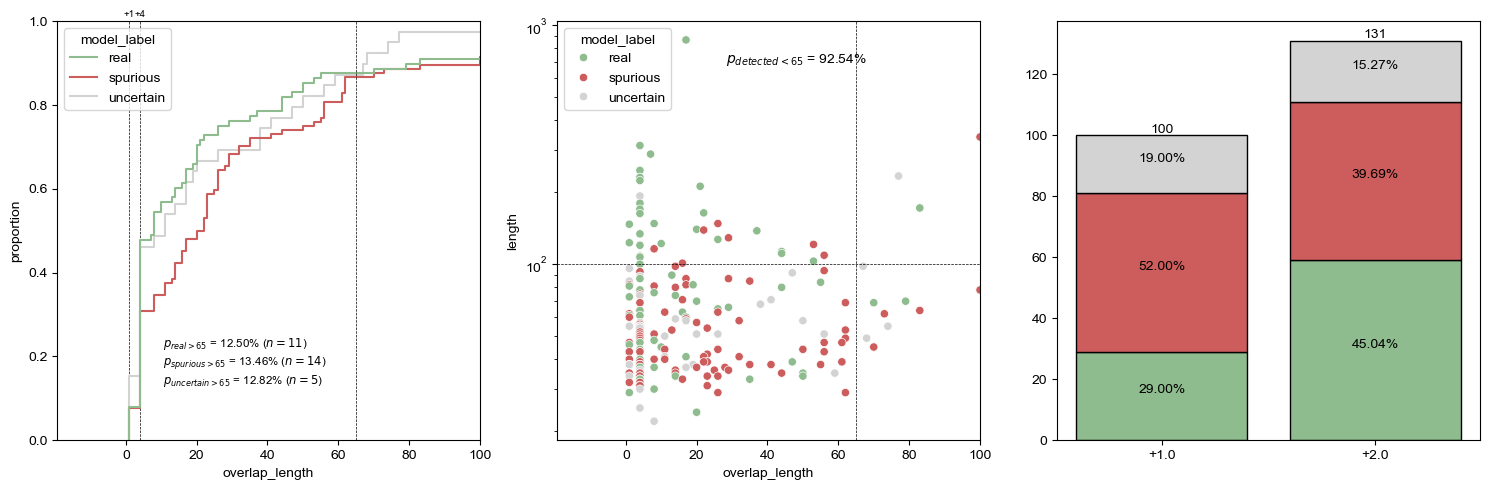

In [16]:
def si_figure(results_df:pd.DataFrame, overlap_length:int=65):

    figure_df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'tandem')].copy()
    # figure_df['phase'] = results_df.overlap_length % 3
    figure_df = figure_df[figure_df.phase != 0].copy()

    # The majority of tandem overlaps have fewer than 60 bp in conflict (as many are detected by Prodigal)
    fig, (ax_a, ax_b, ax_c) = plt.subplots(figsize=(15, 5), ncols=3)
    palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}

    def panel_a(ax_df:pd.DataFrame, ax=None):
        sns.ecdfplot(ax_df, hue='model_label', palette=palette, ax=ax, x='overlap_length')
        ax.set_xlim(xmax=100)

        text = ''
        for model_label, df in ax_df.groupby('model_label'):
            n = (df.overlap_length > overlap_length).sum()
            text += '$p_{' + model_label + '>' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
        ax.text(0.25, 0.1, text, transform=ax.transAxes, fontsize='small')
        ax.axvline(x=overlap_length, color='black', ls='--', lw=0.5)
        ax.axvline(x=4, color='black', ls='--', lw=0.5, zorder=-1)
        ax.text(4, 1.01, '+4', fontsize='x-small', ha='center')
        ax.text(1, 1.01, '+1', fontsize='x-small', ha='center')
        ax.axvline(x=1, color='black', ls='--', lw=0.5, zorder=-1)
        ax.set_ylabel('proportion')
        sns.move_legend(ax, loc='upper left')

    def panel_b(ax_df:pd.DataFrame, ax=None):
        sns.scatterplot(ax_df, hue='model_label', palette=palette, ax=ax, x='overlap_length', y='length')
        ax.set_xlim(xmax=100)
        ax.set_yscale('log')
        # ax_a.set_ylim(ymax=300)
        sns.move_legend(ax, loc='upper left')
        ax.axvline(x=overlap_length, color='black', ls='--', lw=0.5)
        ax.axhline(y=100, color='black', ls='--', lw=0.5)

        text = '$p_{detected<65}$ = '
        text += f'{get_percent(((ax_df.overlap_length < overlap_length) & ax_df.top_hit_match_in_conflict).sum(), (ax_df.overlap_length < overlap_length).sum())}'
        ax.text(0.4, 0.9, text, transform=ax.transAxes)

    def panel_c(ax_df:pd.DataFrame, ax=None):
        phases = sorted(figure_df.phase.unique())
        # ax_df = ax_df[ax_df.overlap_length > 7]

        positions = np.arange(len(phases))
        totals = ax_df.groupby('phase').apply(len, include_groups=False).loc[phases]
        bottom = np.zeros(len(phases))

        for model_label, df in ax_df.groupby('model_label'):
            heights = np.array([(df.phase == phase).sum() for phase in phases])
            ax.bar(positions, heights, bottom=bottom, edgecolor='black', label=model_label, color=palette[model_label])
            for x, y, n, total in zip(positions, bottom + heights / 2, heights, totals):
                if n > 5:
                    ax.text(x, y, get_percent(n, total), ha='center', va='bottom')
            bottom += np.array(heights)

        for x, y in zip(positions, totals):
            ax.text(x, y, str(int(y)), ha='center', va='bottom')

        ax.set_xticks(np.arange(len(phases)), labels=[f'+{phase}' for phase in phases])

    panel_a(figure_df, ax=ax_a)
    panel_b(figure_df, ax=ax_b)
    panel_c(figure_df, ax=ax_c)

    figure_df = figure_df[figure_df.real].copy()
    print('Num. real tandem +1 overlaps:', (figure_df.overlap_length == 1).sum(), f'({get_percent((figure_df.overlap_length == 1).sum(), len(figure_df))})')
    print('Num. real tandem +4 overlaps:', (figure_df.overlap_length == 4).sum(), f'({get_percent((figure_df.overlap_length == 4).sum(), len(figure_df))})')
    print('Num. real tandem phase +1 overlaps:', (figure_df.phase == 1).sum(), f'({get_percent((figure_df.phase == 1).sum(), len(figure_df))})')
    print('Num. real tandem phase +2 overlaps:', (figure_df.phase == 2).sum(), f'({get_percent((figure_df.phase == 2).sum(), len(figure_df))})')

    fig.tight_layout()
    plt.show()

si_figure(results_df)

# Interesting observation here. 90% of both real and spurious-classified sequences have less than about 60 bp overlap. 
# Then overlap length seems to make no difference in the model's decision. Corresponds to the maximum tandem overlap
# length allowed by Prodigal. Are there any conflicts exceeding 60 bp with non-hypothetical proteins?

# Possibly due to the fact that almost every sequence with a query_overlap_fraction > 0.5 is a very short sequence.

# Interesting observation that about half of the valid tandem overlaps are predicted to be spurious. 
# Is there any non-biological reason that Prodigal would predict a high frequency of 1 and 4 bp overlaps with sequences it does not detect?
# Perhaps Prodigal does detect the overlapping sequences. Should check if they have an exact match in the Prodigal genome. 

Removing 1 tandem overlaps with phase 0.


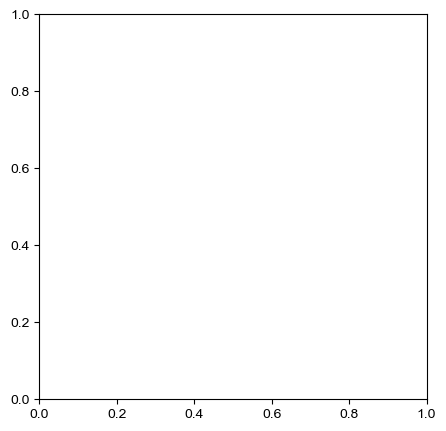

In [412]:
figure_df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'tandem')].copy()
figure_df['phase'] = figure_df.overlap_length % 3
print(f'Removing {((figure_df.phase == 0) & (figure_df.overlap_type == 'tandem')).sum()} tandem overlaps with phase 0.')
figure_df = figure_df[~((figure_df.phase == 0) & (figure_df.overlap_type == 'tandem'))].copy()

fig, ax = plt.subplots(figsize=(5, 5))

palette = {'real':'darkseagreen', 'spurious':'indianred', 'uncertain':'lightgray'}

plt.show()

In [101]:
# figure_df = results_df[is_cds_conflict(results_df) & (results_df.overlap_type == 'convergent')].copy()

# fig, ax = plt.subplots(figsize=(5, 5))

# sns.ecdfplot(figure_df, hue='model_label', palette=palette, ax=ax, x='query_overlap_fraction')
# # ax.set_xlim(xmin=0, xmax=300)

# # overlap_length, text = 60, ''
# # for model_label, df in figure_df.groupby('model_label'):
# #     n = (df.overlap_length > overlap_length).sum()
# #     text += '$p_{' + model_label + '>' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
# # ax.text(0.5, 0.3, text, transform=ax.transAxes, fontsize='small')
# # ax.axvline(x=overlap_length, color='black', ls='--', lw=0.5)

In [ ]:
df = results_df[is_supported_cds_conflict(results_df) & (results_df.overlap_length > 50) & (results_df.model_label == 'real') & (results_df.overlap_type == 'tandem')].copy()
df['repaired'] = df.index.isin(repaired_conflict_ids)
df['top_hit_ab_initio'] = df.top_hit_evidence_type == 'ab initio prediction'
df[['query_overlap_fraction', 'length', 'repaired', 'top_hit_product', 'top_hit_ab_initio', 'overlap_length']]

,query_overlap_fraction,length,repaired,top_hit_product,top_hit_ab_initio,overlap_length
id,,,,,,
NZ_CP130454.1_3168,0.127023,411,True,hypothetical protein,False,157
NZ_NIGF01000022.1_4,0.530556,239,False,hypothetical protein,False,382
NZ_QXIU01000258.1_3,0.159923,172,False,S-layer homology domain-containing protein,False,83
NZ_CP130454.1_299,0.753281,126,False,hypothetical protein,False,287
NC_014960.1_288,0.638889,119,False,ClbS/DfsB family four-helix bundle protein,False,230
NZ_CP063767.1_1564,0.620155,85,True,2-C-methyl-D-erythritol 4-phosphate cytidylylt...,False,160
NZ_AP025523.1_3368,0.490196,84,False,non-homologous end-joining DNA ligase,False,125
NZ_QXIU01000048.1_21,0.370892,70,False,amidohydrolase family protein,False,79


In [ ]:
# Does the ability of an overlap to be repaired have an effect on if it is predicted to be spurious?
# Does whether or not a conflict is "valid" have an effect on if it is predicted spurious?
invalid_conflict_ids = results_df[(~is_valid_overlap(results_df)) & (~results_df.top_hit_unsupported) & results_df.conflict].index.values
valid_conflict_ids = results_df[(is_valid_overlap(results_df)) & (~results_df.top_hit_unsupported) & results_df.conflict].index.values

repaired_conflict_ids = repaired_dataset_df.index.values
unrepaired_conflict_ids = invalid_conflict_ids[~np.isin(invalid_conflict_ids, repaired_conflict_ids)]

results_df[results_df.index.isin(repaired_conflict_ids) & (results_df.model_label == 0)].overlap_type.value_counts() / results_df[results_df.index.isin(repaired_conflict_ids)].overlap_type.value_counts()
results_df[results_df.index.isin(repaired_conflict_ids)].overlap_type.value_counts()
results_df[results_df.index.isin(unrepaired_conflict_ids)].overlap_type.value_counts()


overlap_type
nested        125
convergent    105
tandem         67
divergent      12
Name: count, dtype: int64

In [ ]:
results_df[results_df.index.isin(valid_conflict_ids)].model_label.value_counts() / len(valid_conflict_ids)
results_df[results_df.index.isin(invalid_conflict_ids)].model_label.value_counts() / len(invalid_conflict_ids)

model_label
spurious     0.781671
real         0.148248
uncertain    0.070081
Name: count, dtype: float64

In [ ]:
results_df[results_df.index.isin(invalid_conflict_ids) & (results_df.model_label == 'real')].overlap_type.value_counts() / results_df[results_df.index.isin(invalid_conflict_ids)].overlap_type.value_counts()

overlap_type
convergent    0.095238
divergent     0.037037
nested        0.071429
tandem        0.309735
Name: count, dtype: float64

<Axes: xlabel='query_length', ylabel='Proportion'>

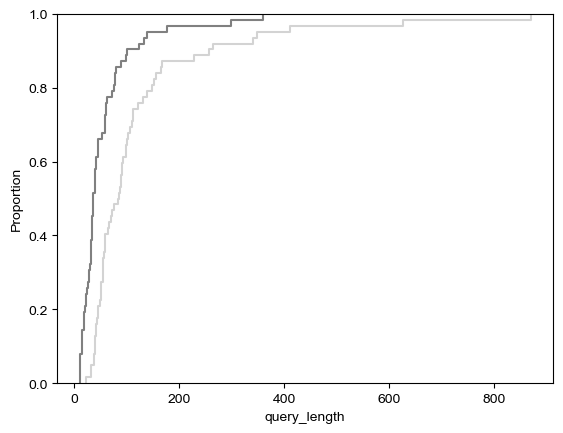

In [ ]:
# Model still seems to predict most of the repairable IDs to be spurious (about half).
repaired_dataset_df['query_length'] = repaired_dataset_df.query_length // 3 # Put in units of amino acids. 
repaired_dataset_df['original_query_length'] = repaired_dataset_df.original_query_length // 3 # Put in units of amino acids. 
sns.ecdfplot(repaired_dataset_df, x='query_length', color='gray')
sns.ecdfplot(repaired_dataset_df, x='original_query_length', color='lightgray')

In [ ]:
multiple_conflict_ids = results_df[(results_df.n_hits > 1) & results_df.conflict].index.values
repaired_conflict_ids = repaired_dataset_df.index.values 

print('Num. repaired conflicts which participate in a second conflict:', len(np.intersect1d(multiple_conflict_ids, repaired_conflict_ids)))

Num. repaired conflicts which participate in a second conflict: 17


In [ ]:
repaired_conflict_mask = results_df.index.isin(repaired_conflict_ids) & ~results_df.index.isin(multiple_conflict_ids)
valid_conflict_mask = repaired_conflict_mask | is_valid_overlap(results_df) | results_df.top_hit_unsupported
results_df['valid_conflict'] = valid_conflict_mask

invalid_conflict_mask = results_df.conflict & ~valid_conflict_mask


results_df[valid_conflict_mask & (results_df.model_label == 0)].overlap_type.value_counts() / results_df[valid_conflict_mask].overlap_type.value_counts()
results_df[invalid_conflict_mask & (results_df.model_label == 0)].overlap_type.value_counts() / results_df[invalid_conflict_mask].overlap_type.value_counts()
# results_df[unrepaired_conflict_mask & (results_df.model_label == 0)].overlap_type.value_counts() / results_df[unrepaired_conflict_mask].overlap_type.value_counts()

overlap_type
convergent    0.815534
divergent     0.916667
nested        0.925532
tandem        0.518519
Name: count, dtype: float64

Num. tandem conflicts: 220
Num. valid tandem conflicts: 190


<Axes: xlabel='overlap_length', ylabel='Proportion'>

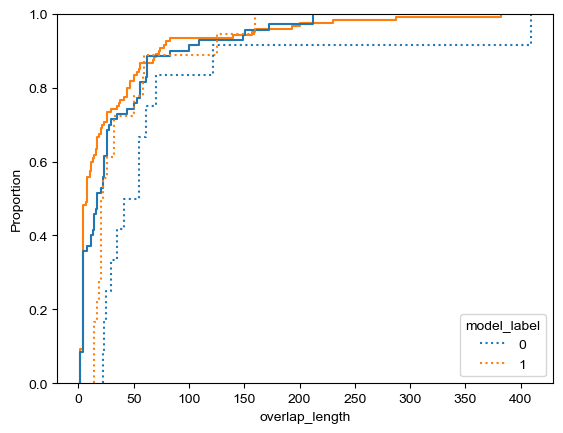

In [ ]:
figure_df = results_df[(results_df.overlap_type == 'tandem') & is_cds_conflict(results_df)].copy()

print('Num. tandem conflicts:', len(figure_df))
print('Num. valid tandem conflicts:', figure_df.valid_conflict.sum())

sns.ecdfplot(figure_df[figure_df.valid_conflict], x='overlap_length', hue='model_label')
sns.ecdfplot(figure_df[~figure_df.valid_conflict], x='overlap_length', hue='model_label', ls=':')

In [ ]:

def get_alternate_coordinates(nt_seq:str=None, start:int=None, stop:int=None, strand:int=None, codon_start:int=1, partial:str=None):
    
    if nt_seq == 'none':
        return np.array([start]), np.array([stop])
    nt_seq = nt_seq[int(codon_start) - 1:]
    
    start_codons = ['AUG', 'GUG', 'UUG']
    codons = np.array([nt_seq[i:i + 3] for i in range(0, len(nt_seq) + 1, 3)])
    start_codon_idxs = np.where(np.isin(codons, start_codons))[0]
    # WP_259095463.1 does not seem to have a start codon?
    if len(start_codon_idxs) == 0:
        return np.array([start]), np.array([stop])
    
    assert (len(nt_seq) % 3 == 0) or is_partial_at_c_terminus(strand, partial), f'get_alternate_coordinates: Nucleotide sequence length should be divisible by three, got {len(nt_seq)}.'
    assert len(''.join(codons)) == len(nt_seq), 'get_alternate_coordinates: Joined codons should have the same length as the original nucleotide sequence.'
    # assert len(start_codon_idxs) >= 1 or is_partial_at_n_terminus(strand, partial), f'get_alternate_starts: Should be at least one start codon. {nt_seq}'

    start_codon_idxs = 3 * start_codon_idxs

    if strand == 1:
        starts = start + start_codon_idxs
        stops = np.array([stop] * len(starts))
    elif strand == -1:
        stops = stop - start_codon_idxs 
        starts = np.array([start] * len(stops))
    return starts, stops 

def get_configurations(row):
    query_starts, query_stops = get_alternate_coordinates(start=row.query_start, stop=row.query_stop, strand=row.query_strand, nt_seq=row.query_nt_seq, partial=row.query_partial)

    config_df = list()
    for query_start, query_stop in zip(query_starts, query_stops):
        config_info = {'query_start':query_start, 'top_hit_start':row.top_hit_start, 'query_stop':query_stop, 'top_hit_stop':row.top_hit_stop}
        config_df.append(config_info)

    config_df = pd.DataFrame(config_df).assign(conflict=True)
    config_df['query_length'] = (config_df.query_stop - config_df.query_start + 1)
    config_df['top_hit_length'] = config_df.top_hit_stop - config_df.top_hit_start + 1
    config_df['original_top_hit_length'] = row.top_hit_stop - row.top_hit_start + 1
    config_df['original_query_length'] = row.query_stop - row.query_start + 1
    config_df['top_hit_strand'] = row.top_hit_strand 
    config_df['query_strand'] = row.query_strand
    config_df['top_hit_feature'] = row.top_hit_feature
    config_df['top_hit_unsupported'] = row.top_hit_unsupported
    config_df['top_hit_pseudo'] = row.top_hit_pseudo
    config_df['original_overlap_type'] = row.overlap_type 
    config_df['overlap_length'] = config_df.apply(get_overlap_length, axis=1)
    config_df['overlap_type'] = config_df.apply(get_overlap_type, axis=1).values # .values # Should re-assign overlap type following coordinate modifications.
    return config_df

is_valid_cds_overlap = lambda df : is_cds_conflict(df) & df.overlap_type.isin(['tandem', 'convergent']) & df.overlap_length.isin([1, 4])
is_valid_overlap = lambda df : is_valid_cds_overlap(df) | ((df.overlap_length == 0) & df.conflict)

def get_configuration_info(row, min_length:int=30):
    # How to pick the best configuration? Perhaps the one with the smallest overlap length, as well as the one where the sum of the query and top hit lengths is the largest.
    # Actually makes more sense to allow larger truncations of the longer sequences, so perhaps try to preserve the largest mean fraction. 
    config_df = get_configurations(row)
    config_df = config_df[(config_df.query_length >= min_length) & (config_df.query_length >= min_length)].copy()
    config_df = config_df[is_valid_overlap(config_df)]
    if len(config_df) == 0:
        return None 
    
    best_overlap_length = config_df.overlap_length.min()
    config_df = config_df[config_df.overlap_length == best_overlap_length].copy()
    config_df = config_df.sort_values(by='query_length', ascending=False) #, key=lambda col : config_df.top_hit_length + config_df.query_length, ascending=False)
    config_info = config_df.iloc[0].to_dict()
    config_info.update({'id':row.Index})
    config_info.update({'original_overlap_length':row.overlap_length})
    return config_info

def repair(dataset_df:pd.DataFrame):
    dataset_df = dataset_df[(~dataset_df.top_hit_unsupported) & (dataset_df.conflict)].copy()
    print('Num. conflicts with supported genetic elements:', len(dataset_df))
    print('Num. repairable conflicts:', is_conflict_from_n_terminal_extension(dataset_df).sum())
    print('Num. invalid conflicts:', (~is_valid_overlap(dataset_df)).sum())
    print('Num. repairable invalid conflicts:', (is_conflict_from_n_terminal_extension(dataset_df) & ~is_valid_overlap(dataset_df)).sum())

    dataset_df = dataset_df[is_conflict_from_n_terminal_extension(dataset_df) & ~is_valid_overlap(dataset_df)].copy()
    repaired_dataset_df = list()
    for row in dataset_df.itertuples():
        config_info = get_configuration_info(row)
        if config_info is None:
            continue
        repaired_dataset_df.append(config_info)
    repaired_dataset_df = pd.DataFrame(repaired_dataset_df).set_index('id')
    return repaired_dataset_df

# NZ_CP065383.1_54
# repaired_dataset_df = repair(dataset_df)

In [ ]:
# # TODO: Compute and report Mann-Whitney test statistics for the ECDF curve differences. 
# # TODO: Should I mention the fact that overlap length is confounded by overlap orientation?
# # TODO: Statistical test showing differences in the antisense vs. sense composition of spurious- and real-labeled sequences. 
# # "Because antisense conflicts are generally larger than sense conflicts (SI Figure 3.2.2), it is unclear if overlap length is itself significant, 
# # or if the observed difference is a byproduct of model sensitivity to antisense overlap."

# def si_figure_3(results_df:pd.DataFrame):
#     '''
#     (A) A summary of model predictions on conflicting sequences; the fraction of antisense conflicts in each category is indicated by the hatched fill. 
#     Spurious-labeled sequences conflicting with supported CDS are significantly more likely to overlap on the antisense strand (p < 1e-11) than their real-labeled counterparts.
#     This effect is far less pronounced for sequences conflicting with unsupported CDS (p > 1e-2).
    
#     (B) ECDF curves of the overlap lengths for conflicts with supported (solid lines) and unsupported (dashed lines) CDS; p_spurious and p_real 
#     are the percentages of conflicts with supported CDS which exceed 10 amino acids in length. Spurious-labeled sequences conflicting with supported CDS have substantially larger
#     overlaps than their real-labeled counterparts. Interestingly, there is no significant difference in the ECDF curves of spurious- and real-classified sequences in conflict with
#     unsupported CDS. The results presented in (A) and (B) suggest that the model is not sensitive to conflict with unsupported CDS.'''

#     figure_df = results_df[results_df.conflict][['top_hit_feature', 'same_strand', 'model_label', 'top_hit_unsupported', 'overlap_length', 'antifam_hit', 'query_overlap_fraction']].copy()
#     figure_df['conflict_with_cds'] = figure_df.top_hit_feature == 'CDS'
#     figure_df['conflict_with_unsupported_cds'] = (figure_df.top_hit_feature == 'CDS') & (figure_df.top_hit_unsupported)
#     figure_df['conflict_with_confirmed_cds'] = (figure_df.top_hit_feature == 'CDS') & (~figure_df.top_hit_unsupported)
#     figure_df['conflict_with_non_coding'] = ~figure_df.conflict_with_cds

#     fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)

#     width = 0.4
#     offsets = {'real': -width/2, 'spurious':width/2}

#     ax_a_df = figure_df.copy()
#     categories = ['confirmed_cds', 'unsupported_cds', 'non_coding']
#     conditions = [ax_a_df.conflict_with_confirmed_cds, ax_a_df.conflict_with_unsupported_cds, ax_a_df.conflict_with_non_coding]
#     ax_a_df['category'] = np.select(conditions, categories, default='none')
#     ax_a_df['model_label'] = np.where(ax_a_df.model_label == 1, 'real', 'spurious')

#     palette = {'real':'darkseagreen', 'spurious':'indianred'}
#     for model_label, df in ax_a_df.groupby('model_label'):
#         ax_df = pd.DataFrame(index=categories)
#         ax_df['total'] = df.category.value_counts()
#         ax_df['fraction'] = df.groupby('category', observed=True).apply(lambda df : (df.same_strand).sum() / len(df), include_groups=False)
#         ax_df['same_strand'] = ax_df['total'] * ax_df['fraction']
#         ax_df['opposite_strand'] = ax_df['total'] * (1 - ax_df['fraction'])
#         positions = np.arange(ax_a_df.category.nunique())
#         ax_a.bar(positions + offsets[model_label], ax_df.opposite_strand,color=palette[model_label], edgecolor='black', hatch='//', width=width)
#         ax_a.bar(positions + offsets[model_label], ax_df.same_strand, bottom=ax_df.opposite_strand, color=palette[model_label], edgecolor='black', width=width)

#         for x, total in zip(positions + offsets[model_label], ax_df.total):
#             text = total
#             ax_a.text(x, total, text, ha='center', fontsize='small', va='bottom')

#     ax_a.set_xticks(positions, labels=ax_df.index)
#     ax_a.set_ylabel('count')

#     text = ''
#     for category, df in ax_a_df.groupby('category'):
#         n = (df.model_label == 'spurious').sum()
#         category = category.replace('_', ' ').replace('cds', '')
#         text += '$p_{' + category + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
#     ax_a.text(0.5, 0.7, text, transform=ax_a.transAxes, fontsize='small')


#     ax_b_df = figure_df[figure_df.conflict_with_cds].copy()
#     ax_b_df['overlap_length'] = ax_b_df.overlap_length // 3 # Convert to units of amino acids. 
#     ax_b_df['model_label'] = np.where(ax_b_df.model_label == 0, 'spurious', 'real')
#     palette = {'real':'darkseagreen', 'spurious':'indianred'}
#     sns.ecdfplot(ax=ax_b, data=ax_b_df[ax_b_df.top_hit_unsupported], hue='model_label', x='overlap_length', palette=palette, ls=':')
#     sns.ecdfplot(ax=ax_b, data=ax_b_df[~ax_b_df.top_hit_unsupported], hue='model_label', x='overlap_length', palette=palette)

#     text = ''
#     overlap_length = 10
#     for model_label, df in ax_b_df[~ax_b_df.top_hit_unsupported].groupby('model_label'):
#         n_overlap_greater_than = (df.overlap_length > overlap_length).sum()
#         text += '$p_{' + model_label + '>' + str(overlap_length) + '}$' + f' = {get_percent(n_overlap_greater_than, len(df))} ($n={n_overlap_greater_than}$)\n'
#     ax_b.text(0.5, 0.5, text, transform=ax_b.transAxes, fontsize='small')
#     ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

#     ax_b.set_xlim(xmax=200, xmin=0)
#     ax_b.set_title('CDS overlap')
#     ax_b.set_ylabel('proportion')

#     fig.tight_layout()
#     plt.show()

# # Could add some annotation to panel A... What summary statistics might be helpful?
# si_figure_3(results_df)

In [ ]:
get_supported_cds_conflicts = lambda df : df[(~df.top_hit_unsupported) & (df.top_hit_feature == 'CDS') & (df.conflict)].copy()
get_unsupported_cds_conflicts = lambda df : df[(df.top_hit_unsupported) & (df.top_hit_feature == 'CDS') & (df.conflict)].copy()

n_spurious = (get_supported_cds_conflicts(results_df).model_label == 0).sum()
n_real = (get_supported_cds_conflicts(results_df).model_label == 1).sum()

f_observed_supported_cds = get_supported_cds_conflicts(results_df).value_counts(['model_label', 'same_strand']).loc[[1, 0]].values
f_expected_supported_cds = [0.5 * n_real, 0.5 * n_real, 0.5 * n_spurious, 0.5 * n_spurious]

n_spurious = (get_unsupported_cds_conflicts(results_df).model_label == 0).sum()
n_real = (get_unsupported_cds_conflicts(results_df).model_label == 1).sum()

f_observed_unsupported_cds = get_unsupported_cds_conflicts(results_df).value_counts(['model_label', 'same_strand']).loc[[1, 0]].values
f_expected_unsupported_cds = [0.5 * n_real, 0.5 * n_real, 0.5 * n_spurious, 0.5 * n_spurious]

print('Chi-squared test for sense versus antisense conflict with unsupported CDS:', chisquare(f_observed_unsupported_cds, f_expected_unsupported_cds).pvalue)
print('Chi-squared test for sense versus antisense conflict with supported CDS:', chisquare(f_observed_supported_cds, f_expected_supported_cds).pvalue)

Chi-squared test for sense versus antisense conflict with unsupported CDS: 0.01649342370904482
Chi-squared test for sense versus antisense conflict with supported CDS: 3.3654563318712514e-11


In [ ]:
    # for same_strand, df in figure_df.groupby('same_strand'):
    #     ax_a_df = pd.DataFrame(index=categories)
    #     ax_a_df['total'] = df.category.value_counts()
    #     ax_a_df['log_total'] = np.log10(ax_a_df['total'] + 0.5)
    #     ax_a_df['fraction'] = df.groupby('category').apply(lambda df : df.top_hit_unsupported.sum() / len(df), include_groups=False)
    #     ax_a_df['unsupported'] = ax_a_df['log_total'] * ax_a_df['fraction']
    #     ax_a_df['supported'] = ax_a_df['log_total'] * (1 - ax_a_df['fraction'])

    #     ax_a.bar(positions + offsets[same_strand], ax_a_df.unsupported, color=palette[same_strand], edgecolor='black', hatch='///', width=width)
    #     ax_a.bar(positions + offsets[same_strand], ax_a_df.supported, bottom=ax_a_df.unsupported, color=palette[same_strand], edgecolor='black', width=width)
        
    #     for x, total, log_total in zip(positions + offsets[same_strand], ax_a_df.total, ax_a_df.log_total):
    #         # text = f'{100 * total / ax_a_df.total.sum():.2f}%'
    #         text = str(total)
    #         ax_a.text(x, log_total, text, ha='center', fontsize='small', va='bottom')

In [ ]:
# is_partial_at_c_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == -1) or ((partial[-1] == '1') and (strand == 1))
# is_partial_at_n_terminus = lambda strand, partial : ((partial[0] == '1')) and (strand == 1) or ((partial[-1] == '1') and (strand == -1))

# is_query_partial_at_c_terminus = lambda row : is_partial_at_c_terminus(row.query_strand, row.query_partial)
# is_top_hit_partial_at_n_terminus = lambda row : ((row.top_hit_partial == '01') and (row.top_hit_strand == 1)) or ((row.top_hit_partial == '10') and (row.top_hit_strand == -1))
# is_top_hit_cds = lambda row : (row.top_hit_feature == 'CDS') and not row.top_hit_pseudo

# # Overlaps greater than 60 bp are almost certainly spurious. However, the proteins could still be in-frame with a genuine ORF, and the 
# # overlap may be the result of a boundary error. Sequences can be extended at the N-terminus due to erroneous start-codon selection, or extended 
# # at the C-terminus due to a frameshift mutation. N-terminal extensions are the most common cause of overlap, and also the simplest to detect, 
# # so will probably limit analysis to these. 

# # Conflicts that are potentially the result of N-terminal extension include:
# # (1) Divergent overlaps where one or both sequence coordinates are the product of ab initio prediction. 
# # (2) Tandem overlaps where the downstream sequence coordinates are the product of ab initio prediction. 
# # (2) Nested overlaps where one or both sequence coordinates are the product of ab initio prediction. 

# query_start_in_top_hit = lambda df : (df.query_start <= df.top_hit_stop) & (df.query_start >= df.top_hit_start)
# query_stop_in_top_hit = lambda df : (df.query_stop <= df.top_hit_stop) & (df.query_stop >= df.top_hit_start)
# top_hit_start_in_query = lambda df : (df.top_hit_start <= df.query_stop) & (df.top_hit_start >= df.query_start)
# top_hit_stop_in_query = lambda df : (df.top_hit_stop <= df.query_stop) & (df.top_hit_stop >= df.query_start)

# is_conflict_at_query_n_terminus = lambda df : (df.query_strand == 1) & query_start_in_top_hit(df) | ((df.query_strand == -1) & query_stop_in_top_hit(df))
# is_conflict_at_top_hit_n_terminus = lambda df : ((df.top_hit_strand == 1) & top_hit_start_in_query(df) | ((df.top_hit_strand == -1) & top_hit_stop_in_query(df)))

# def get_alternate_coordinates(nt_seq:str=None, start:int=None, stop:int=None, strand:int=None, codon_start:int=1, partial:str=None):
    
#     if nt_seq == 'none':
#         return np.array([start]), np.array([stop])
#     nt_seq = nt_seq[int(codon_start) - 1:]
    
#     start_codons = ['AUG', 'GUG', 'UUG']
#     codons = np.array([nt_seq[i:i + 3] for i in range(0, len(nt_seq) + 1, 3)])
#     start_codon_idxs = np.where(np.isin(codons, start_codons))[0]
#     # WP_259095463.1 does not seem to have a start codon?
#     if len(start_codon_idxs) == 0:
#         return np.array([start]), np.array([stop])
    
#     assert (len(nt_seq) % 3 == 0) or is_partial_at_c_terminus(strand, partial), f'get_alternate_coordinates: Nucleotide sequence length should be divisible by three, got {len(nt_seq)}.'
#     assert len(''.join(codons)) == len(nt_seq), 'get_alternate_coordinates: Joined codons should have the same length as the original nucleotide sequence.'
#     # assert len(start_codon_idxs) >= 1 or is_partial_at_n_terminus(strand, partial), f'get_alternate_starts: Should be at least one start codon. {nt_seq}'

#     start_codon_idxs = 3 * start_codon_idxs

#     if strand == 1:
#         starts = start + start_codon_idxs
#         stops = np.array([stop] * len(starts))
#     elif strand == -1:
#         stops = stop - start_codon_idxs 
#         starts = np.array([start] * len(stops))
#     return starts, stops 

# has_overlap = lambda row : not ((row.query_stop < row.top_hit_start) or (row.query_start > row.top_hit_stop))
# get_overlap_length = lambda row : 0 if not has_overlap(row) else min(row.query_stop, row.top_hit_stop) - max(row.query_start, row.top_hit_start)
# get_overlap_type = lambda row : reference.get_overlap_type(query_start=row.query_start, query_stop=row.query_stop, subject_start=row.top_hit_start, subject_stop=row.top_hit_stop, query_strand=row.query_strand, subject_strand=row.top_hit_strand)

# is_top_hit_coordinate_adjustable = lambda row : is_top_hit_cds(row) and not (('programmed frameshift' in row.top_hit_note) | (row.top_hit_evidence_source == 'similar to AA sequence'))

# def get_configurations(row):
#     query_starts, query_stops = get_alternate_coordinates(start=row.query_start, stop=row.query_stop, strand=row.query_strand, nt_seq=row.query_nt_seq, partial=row.query_partial)
#     if is_top_hit_coordinate_adjustable(row):
#         top_hit_starts, top_hit_stops = get_alternate_coordinates(start=row.top_hit_start, stop=row.top_hit_stop, strand=row.top_hit_strand, nt_seq=row.top_hit_nt_seq, partial=row.top_hit_partial, codon_start=row.top_hit_codon_start)
#     else:
#         top_hit_starts, top_hit_stops = ([row.top_hit_start], [row.top_hit_stop])

#     config_df = list()
#     for query_start, query_stop in zip(query_starts, query_stops):
#         for top_hit_start, top_hit_stop in zip(top_hit_starts, top_hit_stops):
#             config_info = {'query_start':query_start, 'top_hit_start':top_hit_start, 'query_stop':query_stop, 'top_hit_stop':top_hit_stop}
#             config_df.append(config_info)
#     config_df = pd.DataFrame(config_df).assign(conflict=True)
#     config_df['query_length'] = (config_df.query_stop - config_df.query_start + 1)
#     config_df['top_hit_length'] = config_df.top_hit_stop - config_df.top_hit_start + 1
#     config_df['original_top_hit_length'] = row.top_hit_stop - row.top_hit_start + 1
#     config_df['original_query_length'] = row.query_stop - row.query_start + 1
#     config_df['top_hit_strand'] = row.top_hit_strand 
#     config_df['query_strand'] = row.query_strand
#     config_df['top_hit_feature'] = row.top_hit_feature
#     config_df['top_hit_pseudo'] = row.top_hit_pseudo
#     config_df['original_overlap_type'] = row.overlap_type 
#     config_df['overlap_length'] = config_df.apply(get_overlap_length, axis=1)
#     config_df['overlap_type'] = config_df.apply(get_overlap_type, axis=1).values # .values # Should re-assign overlap type following coordinate modifications.
#     return config_df

# is_valid_cds_overlap = lambda df : is_cds_conflict(df) & df.overlap_type.isin(['tandem', 'convergent', 'none']) & df.overlap_length.isin([0, 1, 4])
# is_valid_overlap = lambda df : is_valid_cds_overlap(df) | ((df.overlap_length == 0) & df.conflict)

# def get_configuration_info(row, min_length:int=30):
#     # How to pick the best configuration? Perhaps the one with the smallest overlap length, as well as the one where the sum of the query and top hit lengths is the largest.
#     # Actually makes more sense to allow larger truncations of the longer sequences, so perhaps try to preserve the largest mean fraction. 
#     config_df = get_configurations(row)
#     config_df = config_df[(config_df.query_length >= min_length) & (config_df.query_length >= min_length)].copy()
#     config_df = config_df[is_valid_overlap(config_df)]
#     if len(config_df) == 0:
#         return None 
    
#     best_overlap_length = config_df.overlap_length.min()
#     config_df = config_df[config_df.overlap_length == best_overlap_length].copy()
#     config_df['score'] = (config_df.query_length / config_df.original_query_length + config_df.top_hit_length / config_df.original_top_hit_length) / 2
#     # config_df = config_df.sort_values(by='query_length', key=lambda col : config_df.top_hit_length + config_df.query_length, ascending=False)
#     config_df = config_df.sort_values(by='score', ascending=False) #, key=lambda col : config_df.top_hit_length + config_df.query_length, ascending=False)
    
#     config_info = config_df.iloc[0].to_dict()
#     config_info.update({'id':row.Index})
#     config_info.update({'original_overlap_length':row.overlap_length})
#     return config_info


# is_conflict_from_n_terminal_extension = lambda df : df.conflict & (is_conflict_at_query_n_terminus(df) | is_conflict_at_top_hit_n_terminus(df)) # & ~(df.top_hit_evidence_source == 'similar to AA sequence')))

# print('Num. possible conflicts due to N-terminal extension:', is_conflict_from_n_terminal_extension(dataset_df).sum())
# print('Num. invalid conflicts due to N-terminal extension:', (is_conflict_from_n_terminal_extension(dataset_df) & ~is_valid_overlap(dataset_df)).sum())

# repairable_conflict_df = dataset_df[is_conflict_from_n_terminal_extension(dataset_df) & ~is_valid_overlap(dataset_df)] # & ~is_valid_overlap(dataset_df)]
# repaired_conflict_df = list()
# for row in repairable_conflict_df.itertuples():
#     config_info = get_configuration_info(row)
#     if config_info is None:
#         continue
#     repaired_conflict_df.append(config_info)
# repaired_conflict_df = pd.DataFrame(repaired_conflict_df).set_index('id')

In [ ]:
# Maybe worth characterizing the secondary overlaps too... 
# def si_figure_2(dataset_df:pd.DataFrame, all_hits_df:pd.DataFrame):

#     totals = dataset_df[is_cds_conflict(dataset_df)].overlap_type.value_counts()
#     ids = dataset_df[(dataset_df.n_hits > 1) & is_cds_conflict(dataset_df)].index.values

#     fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)
#     overlap_types = ['divergent', 'convergent', 'tandem', 'nested']

#     positions = np.arange(len(overlap_types))

#     figure_df = list()
#     for id_ in ids:
#         row = {'id':id_}
#         df = all_hits_df[all_hits_df.query_id == id_].sort_values('overlap_length', ascending=False)
#         row['primary_overlap_type'] = df.iloc[0].overlap_type 
#         row['secondary_overlap_type'] = df.iloc[1].overlap_type 
#         row['secondary_overlap_length'] = df.iloc[1].overlap_length 
#         row['secondary_overlap_uncertain'] = (df.iloc[0].subject_evidence_type == 'ab initio prediction') and (df.iloc[0].subject_product == 'hypothetical protein')
#         figure_df.append(row)
#     figure_df = pd.DataFrame(figure_df).set_index('id')

#     ax_a_df = figure_df.groupby('primary_overlap_type').secondary_overlap_type.value_counts()
#     ax_a_df = ax_a_df.reset_index().pivot(columns='primary_overlap_type', index='secondary_overlap_type', values='count').fillna(0)
#     ax_a_df = ax_a_df.loc[['tandem', 'convergent', 'divergent', 'nested']]
    
#     bottom = np.zeros(len(ax_a_df))
#     positions = np.arange(len(ax_a_df))
#     palette = {'tandem':'dimgrey', 'convergent':'gray', 'divergent':'lightgray', 'nested':'white'}
#     for overlap_type in ax_a_df.index:
#         heights = ax_a_df.loc[overlap_type].values
#         ax_a.bar(positions, heights, bottom=bottom, color=palette[overlap_type], edgecolor='black', label=overlap_type, hatch='///' if (overlap_type == 'nested') else None)
#         bottom += heights
#     ax_a.set_xticks(positions, labels=ax_a_df.columns)
#     ax_a.legend()
#     ax_a.set_xlabel('primary_overlap_type')

#     ax_b_df = figure_df[figure_df.secondary_overlap_type != 'nested'].copy()
#     # sns.ecdfplot(data=ax_b_df[ax_b_df.secondary_overlap_uncertain], x='secondary_overlap_length', hue='secondary_overlap_type', ax=ax_b, ls=':')
#     sns.ecdfplot(data=ax_b_df, x='secondary_overlap_length', hue='secondary_overlap_type', ax=ax_b, palette=palette)
#     ax_b.set_ylabel('proportion')

#     overlap_length, text = 30, ''
#     for overlap_type, df in ax_b_df.groupby('secondary_overlap_type'):
#         n = (df.secondary_overlap_length > overlap_length).sum()
#         text += '$p_{' + overlap_type + '>' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
#     ax_b.text(0.5, 0.3, text, transform=ax_b.transAxes, fontsize='small')
#     ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

#     fig.suptitle(f'secondary overlaps ($n={len(figure_df)}$)')
#     fig.tight_layout()
#     plt.show()

# si_figure_2(dataset_df, all_hits_df)